# Анализ работы СМО для солярия
Лектор не дал адрес :(

В этом ноутбуке представлено полное решение задачи, в котором:

- **Аналитическое решение:** подробно расписаны все шаги для получения стационарных вероятностей системы, вычисления основных показателей (абсолютная и относительная пропускная способность, среднее время ожидания, число заявок в очереди, коэффициент использования, потери выручки).
- **Имитационная модель:** реализована дискретно-событийная модель системы \(M/M/2/6\) с использованием библиотеки SimPy. Модель учитывает экспоненциальное распределение времени между поступлениями заявок и временем обслуживания, а также отказ клиентов при переполнении очереди.
- **Анализ сходимости:** выполнен запуск модели для разных периодов моделирования с множеством репликаций, рассчитаны относительные ошибки ключевых показателей по сравнению с теоретическими значениями, построены графики сходимости.

Все результаты и графики позволяют оценить, насколько экспериментальные результаты симуляции сходятся с аналитическими расчётами.


## 1. Аналитическое решение

Мы рассматриваем систему как $M/M/2/6$:

- **Поступления:** Поток Пуассона с интенсивностью $\lambda = 9$ заявок/час.
- **Обслуживание:** Экспоненциальное распределение с $\mu = 3$ обслуживаний/час (среднее время сеанса = 20 минут).
- **Количество аппаратов:** $c = 2$.
- **Ограничение очереди:** Если в очереди уже 4 клиента, то новая заявка отказывается. Таким образом, максимальное число заявок в системе $K = 2 + 4 = 6$.

### Стационарные вероятности

Обозначим $P(n)$ – вероятность того, что в системе находится $n$ заявок. Для системы $M/M/c/K$ имеем:

- Для $n \le c$ (то есть $n = 0, 1, 2$):
  $
  P(n) = \frac{(\lambda/\mu)^n}{n!} \, P(0)
$
- Для $n > c$ (то есть $n = 3,4,5,6$):
  $
  P(n) = \frac{(\lambda/\mu)^n}{c! \, c^{n-c}}\, P(0)
  $

При $\lambda/\mu = 9/3 = 3$ получаем:

- $P(0) = \dfrac{1}{S_1 + S_2},$ где
  $
  S_1 = \sum_{n=0}^{2} \frac{3^n}{n!} = 1 + 3 + 4.5 = 8.5,
  $
  и
  $
  S_2 = \frac{3^2}{2!} \sum_{m=1}^{4} \frac{3^m}{2^m} = 4.5 \times 12.1875 \approx 54.84375.
  $

Таким образом, $P(0) \approx \frac{1}{8.5+54.84375} \approx 0.01579$.

Вычисляя последовательно, получаем:
- $P(1) \approx 0.04737$
- $P(2) \approx 0.07106$
- $P(3) \approx 0.1066$
- $P(4) \approx 0.1598$
- $P(5) \approx 0.2400$
- $P(6) \approx 0.3597$

### Основные показатели СМО

1. **Абсолютная пропускная способность:**
   $
   \lambda_{\text{eff}} = \lambda \cdot (1 - P(6)) \approx 9 \times (1 - 0.3597) \approx 5.7627 \quad \text{заявок/час.}
   $

2. **Относительная пропускная способность:**
   $
   \eta = \frac{\lambda_{\text{eff}}}{\lambda} \approx 0.6403 \quad (64.03\%).
   $

3. **Среднее число заявок в системе:**
   $
   L = \sum_{n=0}^{6} n\,P(n) \approx 4.5067.
   $

4. **Среднее время пребывания заявки в системе:**
   $
   W = \frac{L}{\lambda_{\text{eff}}} \approx 0.782 \; \text{часа} \quad (\approx 46.9 \text{ минут}).
   $

5. **Среднее время ожидания заявки в очереди:**
   $
   W_q = W - \frac{1}{\mu} \approx 0.782 - 0.333 \approx 0.449 \; \text{часа} \quad (\approx 26.9 \text{ минут}).
   $

6. **Среднее число заявок в очереди:**
   $
   L_q = \lambda_{\text{eff}} \cdot W_q \approx 2.59.
   $

7. **Коэффициент использования:**
   $
   \rho = \frac{\lambda_{\text{eff}}}{c\mu} \approx 0.96045 \quad (96.0\%).
   $

8. **Потери выручки:** При отказе ($P(6) \approx 35.97\%$) и цене сеанса 7000 руб:
   $
   R_{\text{сутки}} \approx 9 \times 0.3597 \times 7000 \times 24 \approx 543816 \quad \text{руб.}
   $


## 2. Имитационная модель

Дискретно-событийное моделирование системы $M/M/2/6$

Модель учитывает:
- Поступление заявок по экспоненциальному закону с интенсивностью $\lambda = 9$ заявок/час.
- Обслуживание заявок с экспоненциальным временем (параметр $\mu = 3$ в час).
- Ограничение по вместимости: если в системе $\ge 6$ заявок, клиент уходит (фиксируется отказ).



In [2]:
!pip install simpy

In [14]:
import simpy
import random
import statistics
import matplotlib.pyplot as plt

# Задаем параметры системы
LAMBDA = 9       # интенсивность поступления заявок (заявок/час)
MU = 3           # параметр обслуживания (обслуживаний/час)
NUM_SERVERS = 2  # число аппаратов
QUEUE_CAPACITY = 4  # максимальное число заявок в очереди
SYSTEM_CAPACITY = NUM_SERVERS + QUEUE_CAPACITY  # максимум заявок в системе

def customer(env, name, server, stats):
    """
    Процесс обслуживания клиента:
    - Если система заполнена, клиент уходит (фиксируется отказ).
    - Иначе, клиент ожидает своей очереди, затем обслуживается и фиксируется время ожидания.
    """
    arrival_time = env.now
    # Если в системе уже SYSTEM_CAPACITY клиентов, фиксируем отказ
    if len(server.users) + len(server.queue) >= SYSTEM_CAPACITY:
        stats['lost'] += 1
        return

    with server.request() as req:
        yield req
        wait = env.now - arrival_time
        stats['wait_times'].append(wait)
        service_time = random.expovariate(MU)
        yield env.timeout(service_time)
        stats['served'] += 1

def arrival_process(env, server, stats):
    """
    Генерация клиентов по экспоненциальному закону.
    """
    i = 0
    while True:
        i += 1
        yield env.timeout(random.expovariate(LAMBDA))
        env.process(customer(env, f'Customer_{i}', server, stats))

def run_simulation(sim_time, random_seed=None):
    """
    Запуск симуляции на заданное время (в часах).
    Возвращает:
      - Абсолютная пропускная способность (заявок/час)
      - Среднее время ожидания
      - Количество обслуженных заявок
      - Количество отказов
    """
    if random_seed is not None:
        random.seed(random_seed)
    stats = {'served': 0, 'lost': 0, 'wait_times': []}
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=NUM_SERVERS)
    env.process(arrival_process(env, server, stats))
    env.run(until=sim_time)
    lambda_eff = stats['served'] / sim_time  # заявки/час
    avg_wait = statistics.mean(stats['wait_times']) if stats['wait_times'] else 0
    return lambda_eff, avg_wait, stats['served'], stats['lost']

In [17]:
for sim_time in [24, 48, 96, 192, 384]:
    lambda_eff_sim, avg_wait_sim, served_sim, lost_sim = run_simulation(sim_time, random_seed=42)
    print(f"Симуляция за {sim_time} часов")
    print(f"Обслужено заявок: {served_sim}")
    print(f"Отказано заявок: {lost_sim}")
    print(f"Абсолютная пропускная способность (заявок/час): {lambda_eff_sim:.4f}")
    print(f"Среднее время ожидания (часов): {avg_wait_sim:.4f}")

    # Вычисление потерь выручки
    lost_revenue_per_hour = (lost_sim / sim_time) * 7000
    daily_loss = lost_revenue_per_hour * 24
    print(f"Потеря выручки в сутки (руб.): {daily_loss:.0f}")
    print("-" * 40)  # Разделитель для удобства чтения


Симуляция за 24 часов
Обслужено заявок: 124
Отказано заявок: 75
Абсолютная пропускная способность (заявок/час): 5.1667
Среднее время ожидания (часов): 0.4663
Потеря выручки в сутки (руб.): 525000
----------------------------------------
Симуляция за 48 часов
Обслужено заявок: 259
Отказано заявок: 171
Абсолютная пропускная способность (заявок/час): 5.3958
Среднее время ожидания (часов): 0.4599
Потеря выручки в сутки (руб.): 598500
----------------------------------------
Симуляция за 96 часов
Обслужено заявок: 545
Отказано заявок: 300
Абсолютная пропускная способность (заявок/час): 5.6771
Среднее время ожидания (часов): 0.4423
Потеря выручки в сутки (руб.): 525000
----------------------------------------
Симуляция за 192 часов
Обслужено заявок: 1089
Отказано заявок: 624
Абсолютная пропускная способность (заявок/час): 5.6719
Среднее время ожидания (часов): 0.4594
Потеря выручки в сутки (руб.): 546000
----------------------------------------
Симуляция за 384 часов
Обслужено заявок: 2234
О

## 3. Анализ сходимости

Для оценки сходимости симуляционной модели к теоретическим результатам будем использовать относительную ошибку для двух ключевых показателей:
- Абсолютная пропускная способность $\lambda_{\text{eff}}$.
- Среднее время ожидания $W_q$.

Теоретические значения:
- $\lambda_{\text{eff,th}} \approx 5.7627$ заявок/час,
- $W_{q,th} \approx 0.449$ часа.

Относительная ошибка вычисляется как:
$
E_X = \left| \frac{X_{\text{sim}} - X_{\text{th}}}{X_{\text{th}}} \right|
$

Мы проведем серию симуляций для разных периодов моделирования (например, 24, 48, 96, 192, 384 часов) и для каждого значения времени проведем несколько независимых репликаций. Затем усредним результаты и построим графики зависимости относительной ошибки от времени симуляции.


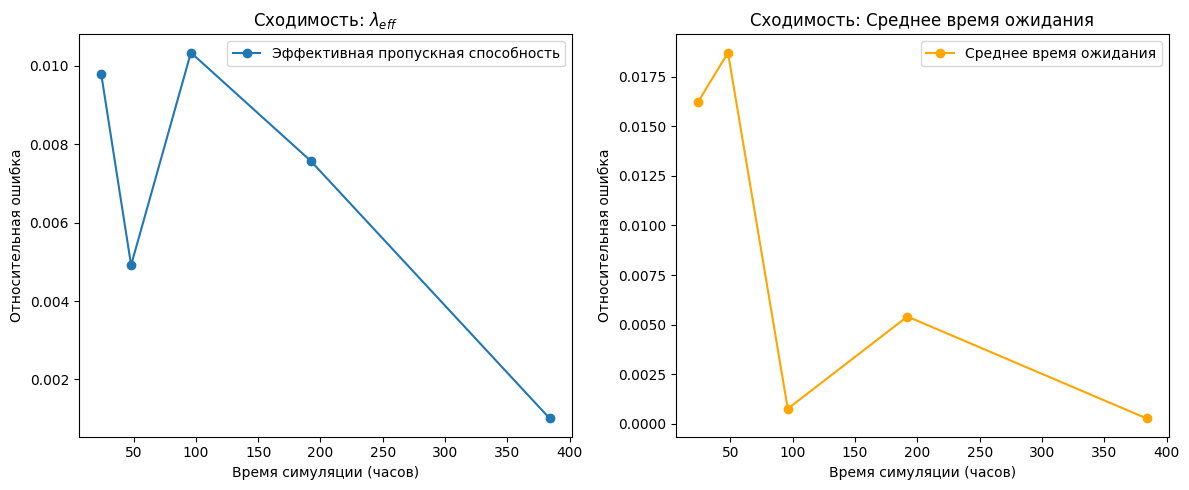

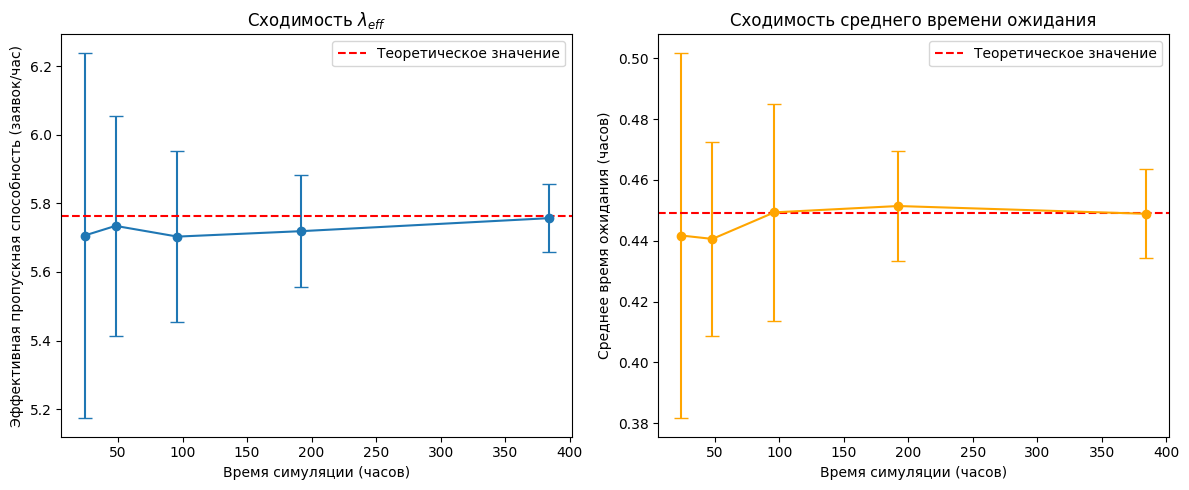

In [6]:
import numpy as np

def convergence_analysis(sim_times,
                         replications=20):
    # Теоретические значения
    lambda_eff_th = 5.7627
    avg_wait_th = 0.449

    results = { 'sim_time': [], 'lambda_eff_mean': [], 'lambda_eff_err': [],
                'avg_wait_mean': [], 'avg_wait_err': [],
                'rel_error_lambda': [], 'rel_error_wait': [] }

    for T in sim_times:
        lambda_eff_vals = []
        avg_wait_vals = []
        for r in range(replications):
            # Для каждой репликации используем различный seed
            lam_eff, avg_wait, _, _ = run_simulation(T, random_seed=r*1234)
            lambda_eff_vals.append(lam_eff)
            avg_wait_vals.append(avg_wait)

        # Усредняем результаты для заданного времени моделирования
        lam_mean = np.mean(lambda_eff_vals)
        wait_mean = np.mean(avg_wait_vals)

        # Стандартное отклонение
        lam_std = np.std(lambda_eff_vals)
        wait_std = np.std(avg_wait_vals)

        # Относительная ошибка
        rel_error_lambda = abs(lam_mean - lambda_eff_th) / lambda_eff_th
        rel_error_wait = abs(wait_mean - avg_wait_th) / avg_wait_th

        results['sim_time'].append(T)
        results['lambda_eff_mean'].append(lam_mean)
        results['lambda_eff_err'].append(lam_std)
        results['avg_wait_mean'].append(wait_mean)
        results['avg_wait_err'].append(wait_std)
        results['rel_error_lambda'].append(rel_error_lambda)
        results['rel_error_wait'].append(rel_error_wait)

    return results

# Определим набор времен симуляции (в часах)
sim_times = [24, 48, 96, 192, 384]
replications = 20

conv_results = convergence_analysis(sim_times, replications)

# Построим графики относительной ошибки для λ_eff и среднего времени ожидания
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(conv_results['sim_time'], conv_results['rel_error_lambda'], 'o-', label='Эффективная пропускная способность')
plt.xlabel('Время симуляции (часов)')
plt.ylabel('Относительная ошибка')
plt.title('Сходимость: $\lambda_{eff}$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(conv_results['sim_time'], conv_results['rel_error_wait'], 'o-', color='orange', label='Среднее время ожидания')
plt.xlabel('Время симуляции (часов)')
plt.ylabel('Относительная ошибка')
plt.title('Сходимость: Среднее время ожидания')
plt.legend()

plt.tight_layout()
plt.show()

# Дополнительно: построим графики изменения средних значений показателей с ошибками
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.errorbar(conv_results['sim_time'], conv_results['lambda_eff_mean'], yerr=conv_results['lambda_eff_err'], fmt='o-', capsize=5)
plt.axhline(5.7627, color='red', linestyle='--', label='Теоретическое значение')
plt.xlabel('Время симуляции (часов)')
plt.ylabel('Эффективная пропускная способность (заявок/час)')
plt.title('Сходимость $\lambda_{eff}$')
plt.legend()

plt.subplot(1,2,2)
plt.errorbar(conv_results['sim_time'], conv_results['avg_wait_mean'], yerr=conv_results['avg_wait_err'], fmt='o-', capsize=5, color='orange')
plt.axhline(0.449, color='red', linestyle='--', label='Теоретическое значение')
plt.xlabel('Время симуляции (часов)')
plt.ylabel('Среднее время ожидания (часов)')
plt.title('Сходимость среднего времени ожидания')
plt.legend()

plt.tight_layout()
plt.show()


## Вывод

- **Сильные флуктуации при малых временах моделирования.**  
  При коротком периоде симуляции (24 часа) система ещё не успевает достичь стационарного режима, поэтому наблюдаются высокие колебания и большая относительная ошибка показателей. Это видно из первых точек на графиках, где ошибка для $\lambda_{\text{eff}}$ и среднего времени ожидания $W_q$ наибольшая.

- **Уменьшение ошибки с ростом времени моделирования.**  
  При увеличении периода моделирования (48, 96, 192, 384 часов) относительная ошибка для показателей $\lambda_{\text{eff}}$ и $W_q$ уменьшается, а средние значения всё ближе к теоретическим. Таким образом, симуляционная модель демонстрирует ожидаемую сходимость к аналитически рассчитанным характеристикам.

- **Влияние числа репликаций.**  
  Несмотря на рост времени моделирования, на графиках заметны колебания, связанные с конечным числом запусков. С увеличением количества репликаций доверительные интервалы сужаются, а усреднённые результаты становятся более стабильными.

- **Моделирование практически совпадает аналитическим решением**  
  На графиках, показывающих усреднённые значения с доверительными интервалами, пунктирные линии соответствуют теоретическим значениям. Экспериментальные оценки с ростом времени моделирования всё меньше отклоняются от этих линий, что подтверждает корректность как аналитической модели $M/M/2/6$, так и реализации имитации.

-
  Для точной оценки показателей системы необходимо либо моделировать достаточно долго, либо проводить несколько независимых симуляций и усреднять результаты. Таким образом, при больших временах (сотни часов) система приближается к стационарному режиму, а относительные ошибки становятся приемлемо низкими.


##Построим ещё графики для дополнительного анализа

In [7]:
def gather_raw_data(sim_times,
                    replications=20):
    """
    Запускает run_simulation(replications) раз для каждого T из sim_times.
    Возвращает словари:
      data_lam[T]  = список из replications значений λ_eff
      data_wait[T] = список из replications значений среднего времени ожидания
    """
    data_lam = {}
    data_wait = {}
    for T in sim_times:
        lam_vals = []
        wait_vals = []
        for r in range(replications):
            lam_eff, avg_wait, _, _ = run_simulation(T, random_seed=r*1234)
            lam_vals.append(lam_eff)
            wait_vals.append(avg_wait)
        data_lam[T] = lam_vals
        data_wait[T] = wait_vals
    return data_lam, data_wait

sim_times = [24, 48, 96, 192, 384]
replications = 20

data_lam, data_wait = gather_raw_data(sim_times, replications)

<ipython-input-8-defa3314052d>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot(lam_data_for_box, labels=sim_times, patch_artist=True)
<ipython-input-8-defa3314052d>:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot(wait_data_for_box, labels=sim_times, patch_artist=True)


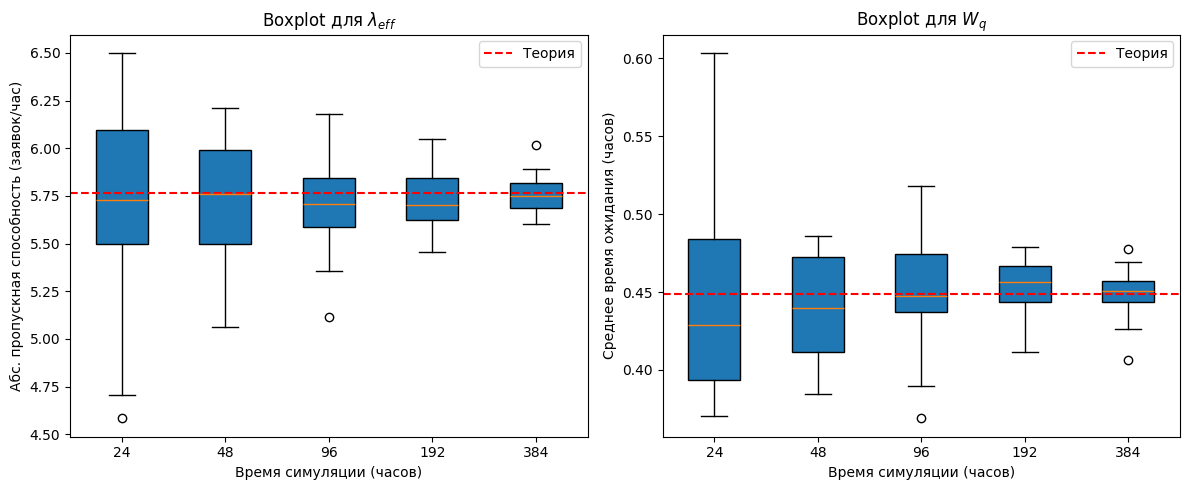

In [8]:
# Теоретические значения
lambda_eff_th = 5.7627
avg_wait_th   = 0.449


lam_data_for_box  = [data_lam[T] for T in sim_times]
wait_data_for_box = [data_wait[T] for T in sim_times]

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Boxplot для λ_eff
ax[0].boxplot(lam_data_for_box, labels=sim_times, patch_artist=True)
ax[0].axhline(lambda_eff_th, color='red', linestyle='--', label='Теория')
ax[0].set_xlabel('Время симуляции (часов)')
ax[0].set_ylabel('Абс. пропускная способность (заявок/час)')
ax[0].set_title('Boxplot для $\\lambda_{eff}$')
ax[0].legend()

# Boxplot для W_q
ax[1].boxplot(wait_data_for_box, labels=sim_times, patch_artist=True)
ax[1].axhline(avg_wait_th, color='red', linestyle='--', label='Теория')
ax[1].set_xlabel('Время симуляции (часов)')
ax[1].set_ylabel('Среднее время ожидания (часов)')
ax[1].set_title('Boxplot для $W_q$')
ax[1].legend()

plt.tight_layout()
plt.show()


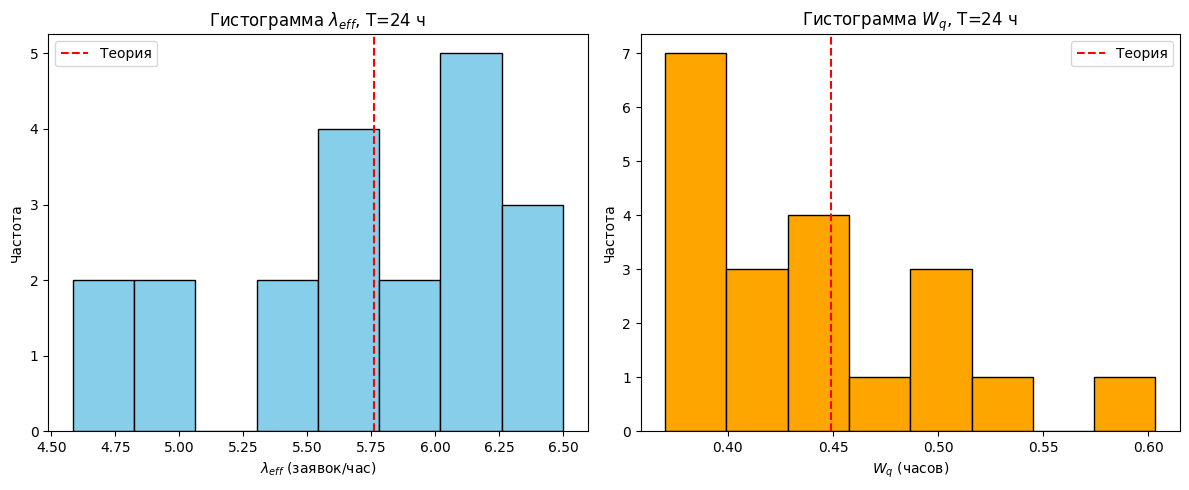

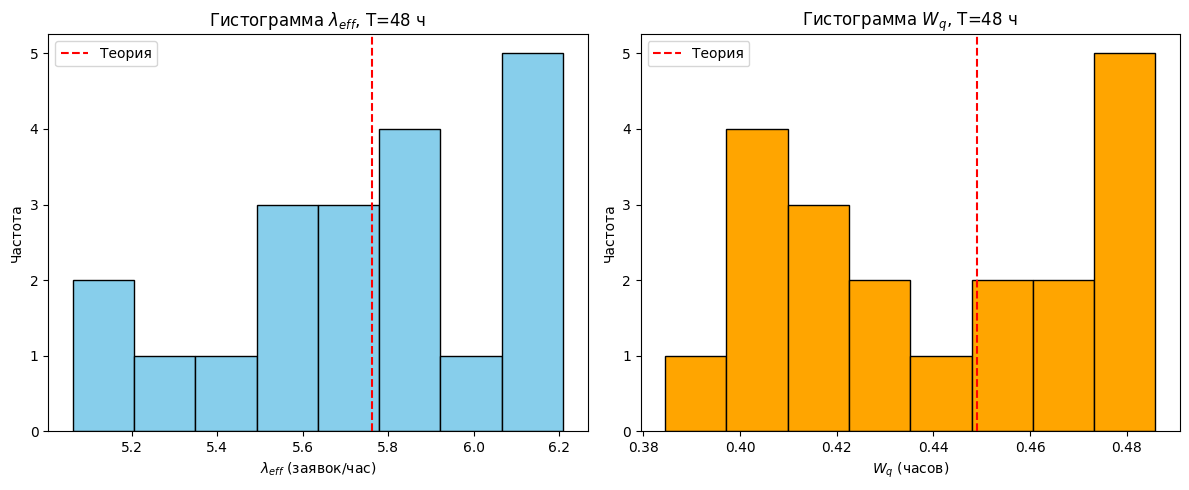

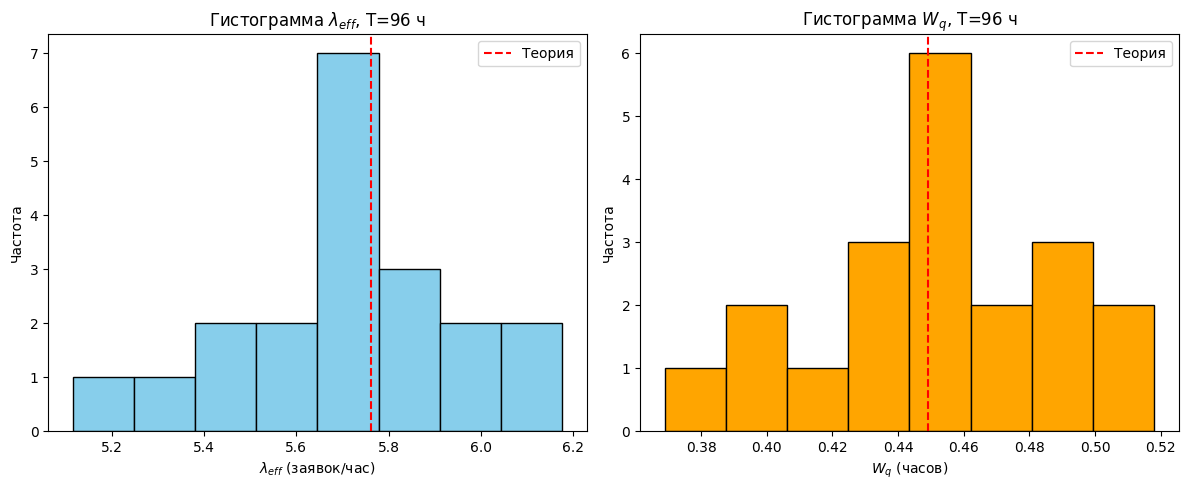

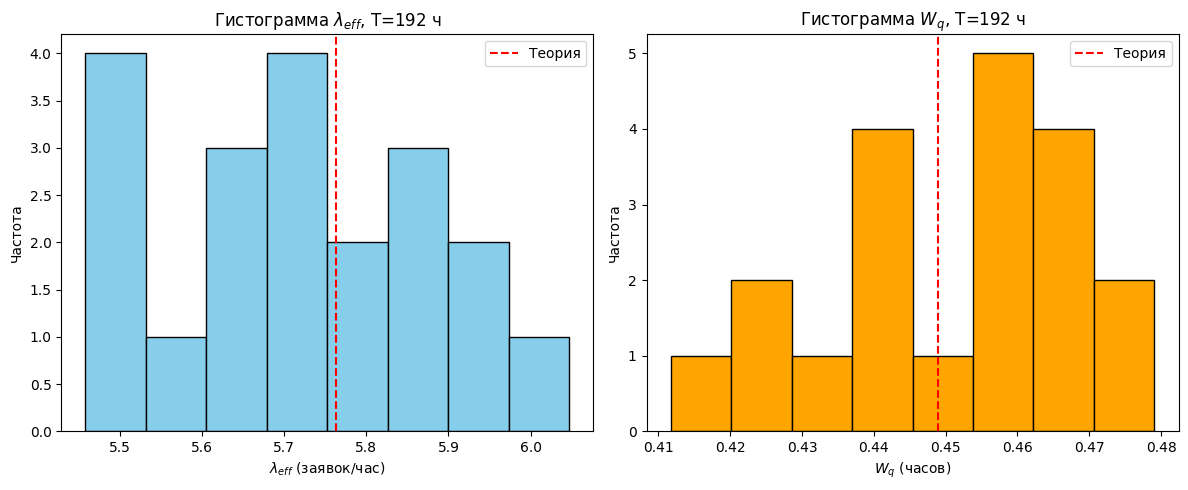

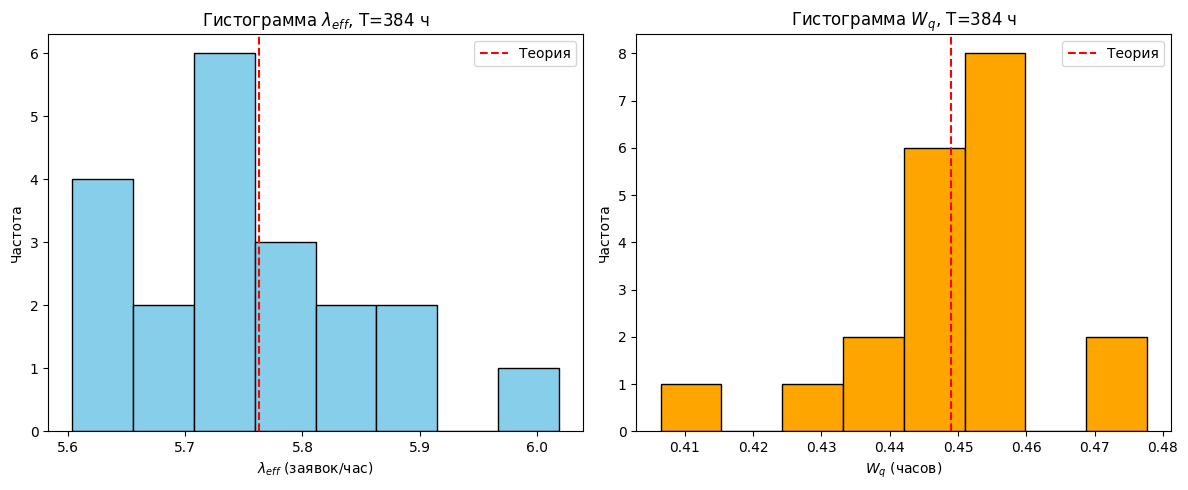

In [11]:
time_list = [24, 48, 96, 192, 384]  # список времен моделирования

for chosen_T in time_list:
    lam_vals = data_lam[chosen_T]
    wait_vals = data_wait[chosen_T]

    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    # Гистограмма для λ_eff
    ax[0].hist(lam_vals, bins=8, color='skyblue', edgecolor='black')
    ax[0].axvline(lambda_eff_th, color='red', linestyle='--', label='Теория')
    ax[0].set_xlabel('$\\lambda_{eff}$ (заявок/час)')
    ax[0].set_ylabel('Частота')
    ax[0].set_title(f'Гистограмма $\\lambda_{{eff}}$, T={chosen_T} ч')
    ax[0].legend()

    # Гистограмма для W_q
    ax[1].hist(wait_vals, bins=8, color='orange', edgecolor='black')
    ax[1].axvline(avg_wait_th, color='red', linestyle='--', label='Теория')
    ax[1].set_xlabel('$W_q$ (часов)')
    ax[1].set_ylabel('Частота')
    ax[1].set_title(f'Гистограмма $W_q$, T={chosen_T} ч')
    ax[1].legend()

    plt.tight_layout()
    plt.show()


## Вывод по гистограммам

- **При коротких временах моделирования** (24–48 часов) распределения значений $\lambda_{\text{eff}}$ и $W_q$ достаточно **широкие**. Многие репликации дают результаты как **ниже**, так и **выше** теоретических линий ($\lambda_{\text{eff}} \approx 5.7627$, $W_q \approx 0.449$). Это нормально: система не успевает «усреднить» случайные колебания за короткий период.

- **При увеличении времени моделирования** (96–192–384 часов) гистограммы сужаются и смещаются ближе к красной пунктирной линии (теоретическому значению). Колебания уменьшаются, и большинство репликаций даёт результат, **близкий** к аналитическим расчётам.

- Таким образом, чем **дольше** идёт симуляция, тем **надёжнее** оцениваются стационарные показатели системы: наблюдается **сходимость** к теоретическим значениям.
